In [2]:
import torch
import torch.nn as nn
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import os
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from torch.utils.data import Subset

In [48]:
dim = 224
num_plots = np.arange(2, 18, 2)
time_points = 241
downsample_scale = 3.3

row_pixels_per_plot = dim/num_plots
indices_per_pixel = time_points/row_pixels_per_plot
real_time_per_pixel = indices_per_pixel*downsample_scale
real_time_per_pixel

array([ 7.10089286, 14.20178571, 21.30267857, 28.40357143, 35.50446429,
       42.60535714, 49.70625   , 56.80714286])

In [ ]:
# model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
# alex_final_only = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
# alex_sudden = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
# alex_descend = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
# alex_gradual = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)

Using cache found in /Users/ciprianbangu/.cache/torch/hub/pytorch_vision_v0.10.0
/opt/homebrew/Caskroom/miniconda/base/envs/neuroai/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/neuroai/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Using cache found in /Users/ciprianbangu/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /Users/ciprianbangu/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /Users/ciprianbangu/.cache/torch/hu

In [4]:
# so the classifier portion has to be changed essentially, i.e., the last nn.Sequential
model.classifier[6] # currently, it is Linear(in:9216, out:4096); Linear(in:4096, out:4096); Linear(in:4096, out:1000)
# we have a 3 class classification problem. 

# so the last layer should be Linear(in:xx, out:3)

Linear(in_features=4096, out_features=1000, bias=True)

In [2]:
# let's give it some options
classifier_sudden = nn.Sequential(
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=9216, out_features=4096), 
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=4096),
    nn.ReLU(inplace=True),
    nn.Linear(in_features=4096, out_features=3)
)

classifier_descend = nn.Sequential(
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=9216, out_features=4096), 
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=2048),
    nn.ReLU(inplace=True),
    nn.Linear(in_features=2048, out_features=3)
)

classifier_gradual_descend_long = nn.Sequential(
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(9216, 4096), 
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=2048),
    nn.ReLU(inplace=True),
    nn.Linear(in_features=2048, out_features=1024),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=1024, out_features=512),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=512, out_features=3)
)

Now there are different ways to train this thing. I can do the one where the convolutional blocks are totally frozen, or we can unfreeze everything, or we can do small learning rate for the conv blocks

In [3]:
def all_but_last_freeze(model):
    for param in model.features.parameters():
        param.requires_grad = False
    for param in model.classifier[:-1].paramters():
        param.requires_grad = False

def full_feature_freeze(model):
    for param in model.features.parameters():
        param.requires_grad = False

def freeze_most(model):
    for param in model.features[-5:].parameters():
        param.requires_grad = False

In [86]:
preprocess = transforms.Compose([
    transforms.Resize(224),
    # transforms.RandomCrop(224),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x[:3, :, :]),  # remove alpha channel
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [87]:
input_image = Image.open("/Users/ciprianbangu/Cogmaster/M2 Internship/BCI code/scalograms_test/images/a_full_channel_2.png")
input_tensor = preprocess(input_image)

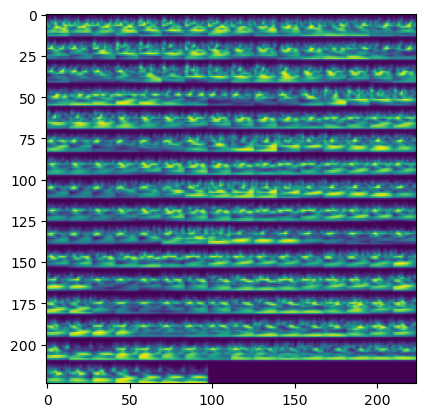

In [88]:
plt.imshow(input_tensor[1])

## Plotting funcs and plotting loops

In [5]:
def plot_scalogram_with_fill(coefs, index, save_dir, label):
    """Plots and saves scalograms for one set of coefficients."""
    fig, axes = plt.subplots(16, 16, figsize=(8, 8))

    # Iterate over channels (coefs has shape (247, 100, 241))
    for ch_idx, channel in enumerate(coefs):                 
        r, c = divmod(ch_idx, 16)
        axes[r, c].pcolormesh(np.abs(channel), cmap='viridis')
        axes[r, c].set_xticks([])
        axes[r, c].set_yticks([])

    # Fill remaining empty subplots with blank images
    for idx in range(coefs.shape[0], 16 * 16):
        r, c = divmod(idx, 16)
        axes[r, c].pcolormesh(np.zeros((50, 241)), cmap='viridis')
        axes[r, c].set_xticks([])
        axes[r, c].set_yticks([])

    # Hide subplot borders
    for ax in axes.flatten():
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)

    plt.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0, wspace=0)
    fig.patch.set_visible(False)

    # Save image
    save_path = os.path.join(save_dir, f"{label}_full_channel_{index}.png")
    plt.savefig(save_path)
    plt.close(fig)  # Close figure to free memory


def plot_average_scalograms(coefs, index, save_dir, label):
    
    fig, axes = plt.subplots(figsize=(8,8))
    
    average = np.mean(np.abs(coefs), axis=0)
    axes.pcolormesh(average)

    axes.set_xticks([])
    axes.set_yticks([])
    axes.spines['top'].set_visible(False)
    axes.spines['right'].set_visible(False)
    axes.spines['left'].set_visible(False)
    axes.spines['bottom'].set_visible(False)

    plt.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0, wspace=0)
    fig.patch.set_visible(False)

    # Save image
    save_path = os.path.join(save_dir, f"{label}_average_channel_{index}.png")
    plt.savefig(save_path)
    plt.close(fig)  # Close figure to free memory


In [ ]:
cwd = os.getcwd()
data_dir = cwd + "/saved_data/"
files = ['a_coefficients_18_2_Feb10.npy', 'e_coefficients_18_2_Feb10.npy', 'i_coefficients_18_2_Feb10.npy']


for file in files:
    coefs = np.load(data_dir + file, mmap_mode='r')
    save_dir = cwd + f"/scalograms_test/images/"
    for i in range(coefs.shape[0]):
            print(f"Processing slice {i+1}/{coefs.shape[0]}")
            plot_scalogram_with_fill(coefs = coefs[i], index = i, save_dir = save_dir, label=file[0])  # Load and process only one slice
    print(f"{file[0]} scalograms completed")

In [100]:
for file in files:
    coefs = np.load(data_dir + file, mmap_mode='r')
    save_dir = cwd + f"/scalograms_test/images_average/"
    for i in range(coefs.shape[0]):
            print(f"Processing slice {i+1}/{coefs.shape[0]}")
            plot_average_scalograms(coefs = coefs[i], index = i, save_dir = save_dir, label=file[0])  # Load and process only one slice
    print(f"{file[0]} scalograms completed")

Processing slice 1/108
Processing slice 2/108
Processing slice 3/108
Processing slice 4/108
Processing slice 5/108
Processing slice 6/108
Processing slice 7/108
Processing slice 8/108
Processing slice 9/108
Processing slice 10/108
Processing slice 11/108
Processing slice 12/108
Processing slice 13/108
Processing slice 14/108
Processing slice 15/108
Processing slice 16/108
Processing slice 17/108
Processing slice 18/108
Processing slice 19/108
Processing slice 20/108
Processing slice 21/108
Processing slice 22/108
Processing slice 23/108
Processing slice 24/108
Processing slice 25/108
Processing slice 26/108
Processing slice 27/108
Processing slice 28/108
Processing slice 29/108
Processing slice 30/108
Processing slice 31/108
Processing slice 32/108
Processing slice 33/108
Processing slice 34/108
Processing slice 35/108
Processing slice 36/108
Processing slice 37/108
Processing slice 38/108
Processing slice 39/108
Processing slice 40/108
Processing slice 41/108
Processing slice 42/108
P

Label Maker

In [ ]:
import csv

# have to make the label CSV
# Get the list of files in the scalograms_test directory
scalogram_files = os.listdir(save_dir)

# Create a CSV file to store the labels
csv_file = os.path.join(save_dir, 'labels.csv')

# Write the file names and labels to the CSV file
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['FileName', 'Label'])  # Write the header

    for file_name in scalogram_files:
        label = file_name.split('_')[0]
        if label == 'a':
            label = 0  # Extract the label from the file name
            writer.writerow([file_name, label])
        elif label == 'e':
            label = 1
            writer.writerow([file_name, label])
        elif label == 'i': 
            label = 2
            writer.writerow([file_name, label])

save_dir = cwd + f"/scalograms_test/images_average/"
# Create a CSV file to store the labels
csv_file = os.path.join(save_dir, 'average_labels.csv')
scalogram_files = os.listdir(save_dir)

# Write the file names and labels to the CSV file
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['FileName', 'Label'])  # Write the header

    for file_name in scalogram_files:
        label = file_name.split('_')[0]
        if label == 'a':
            label = 0  # Extract the label from the file name
            writer.writerow([file_name, label])
        elif label == 'e':
            label = 1
            writer.writerow([file_name, label])
        elif label == 'i': 
            label = 2
            writer.writerow([file_name, label])

# Datasets

In [36]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import pandas as pd

class AlexNetDataClass(Dataset):
    def __init__(self, csv_file, img_directory, transform=None):
        self.data = pd.read_csv(csv_file)
        self.img_directory = img_directory
        self.transform = transform


    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_directory, str(self.data.iloc[idx, 0]))
        label = int(self.data.iloc[idx, 1])

        image = Image.open(img_path)

        if self.transform:
            image = self.transform(image)

        return image, label

In [6]:
dataset = AlexNetDataClass(csv_file="/Users/ciprianbangu/Cogmaster/M2 Internship/BCI code/scalograms_test/labels.csv", 
                           img_directory="/Users/ciprianbangu/Cogmaster/M2 Internship/BCI code/scalograms_test/images",
                           transform=preprocess)

average_dataset = AlexNetDataClass(csv_file="/Users/ciprianbangu/Cogmaster/M2 Internship/BCI code/scalograms_test/average_labels.csv",
                                   img_directory="/Users/ciprianbangu/Cogmaster/M2 Internship/BCI code/scalograms_test/images_average",
                                   transform=preprocess)

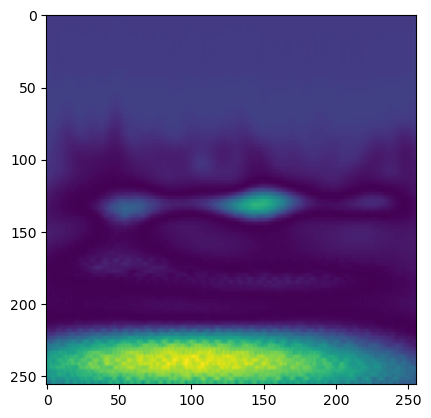

In [7]:
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
images, labels = next(iter(dataloader))
plt.imshow(images[0,0])

dataloader_average = DataLoader(average_dataset, batch_size=16, shuffle=True)
images, labels = next(iter(dataloader_average))
plt.imshow(images[0,0])

# Mock Model Training

In [38]:
class AlexNetMPSFinalOnly(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = models.alexnet(weights=True)

        # Keep all layers as they are, including AdaptiveAvgPool2d
        self.features = self.model.features
        self.avgpool = self.model.avgpool  # This is AdaptiveAvgPool2d
        self.classifier = self.model.classifier
        self.classifier[-1] = nn.Linear(in_features=4096, out_features=3)

    def forward(self, x):
        x = self.features(x)  # Feature extraction
        x = self.avgpool(x.to("cpu")).to(x.device)  # Move to CPU, then back to MPS
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Move model to MPS
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
model = AlexNetMPSFinalOnly().to(device)

/opt/homebrew/Caskroom/miniconda/base/envs/neuroai/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [39]:
model

AlexNetMPSFinalOnly(
  (model): AlexNet(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
    (classifier): Sequential(
      (0): Dropout(p=0.5, inplace=Fals

In [8]:
class AlexNetMPSSuddenDescend(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = models.alexnet(weights=True)

        # Keep all layers as they are, including AdaptiveAvgPool2d
        self.features = self.model.features
        self.avgpool = self.model.avgpool  # This is AdaptiveAvgPool2d
        self.classifier = classifier_sudden

    def forward(self, x):
        x = self.features(x)  # Feature extraction
        x = self.avgpool(x.to("cpu")).to(x.device)  # Move to CPU, then back to MPS
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Move model to MPS
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
# model = AlexNetMPSSuddenDescend().to(device)

In [10]:
class AlexNetMPSLongDescend(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = models.alexnet(weights=True)

        # Keep all layers as they are, including AdaptiveAvgPool2d
        self.features = self.model.features
        self.avgpool = self.model.avgpool  # This is AdaptiveAvgPool2d
        self.classifier = classifier_gradual_descend_long

    def forward(self, x):
        x = self.features(x)  # Feature extraction
        x = self.avgpool(x.to("cpu")).to(x.device)  # Move to CPU, then back to MPS
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Move model to MPS
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
# model = AlexNetMPSLongDescend().to(device)

In [11]:
class AlexNetMPSDescend(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = models.alexnet(weights=True)

        # Keep all layers as they are, including AdaptiveAvgPool2d
        self.features = self.model.features
        self.avgpool = self.model.avgpool  # This is AdaptiveAvgPool2d
        self.classifier = classifier_descend

    def forward(self, x):
        x = self.features(x)  # Feature extraction
        x = self.avgpool(x.to("cpu")).to(x.device)  # Move to CPU, then back to MPS
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Move model to MPS
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
# model = AlexNetMPSDescend().to(device)

Notes: 

alex last layer + freeze features works pretty well on the averaged data, lr 0.001.

Descend with feature freeze and 0.001 lr learns well on averaged data


I think the big scalogram is just way to big for the resolution of the model. I wonder how they did it in the paper?


In [54]:
import seaborn as sns
def plot_confusion_matrix(cm, classes, title="Confusion Matrix"):
    """Plots the confusion matrix as a heatmap."""
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.show()

In [ ]:
def train_val_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device="mps"):
    model.to(device)
    best_val_acc = 0.0

    ### storing lossess and accuracies
    epoch_loss_list, epoch_val_loss_list = [], []
    epoch_acc_list, epoch_val_acc_list = [], []

    ### store f1 metrics 
    epoch_f1_list, epoch_precision_list, epoch_recall_list, epoch_specificity_list = [], [], [], []
    epoch_val_f1_list, epoch_val_precision_list, epoch_val_recall_list, epoch_val_specificity_list = [], [], [], []

    ### epoch looping
    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        all_preds, all_labels = [], [] # to compute metrics

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)  # Sum up batch loss
            _, predicted = outputs.max(1) # predicted class
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            ### storing predicitions
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        ### get accuracy
        epoch_loss = running_loss / len(train_loader.dataset)  # Normalize by dataset size
        epoch_acc = 100.0 * correct / total  # Ensure percentage scaling
        
        ### classification stats
        precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
        recall = recall_score(all_labels, all_preds, average="weighted", zero_division=0)
        f1 = f1_score(all_labels, all_preds, average="weighted", zero_division=0)
        conf_mat = confusion_matrix(all_labels, all_preds)
        specificity = np.mean(conf_mat.diagonal()/ conf_mat.sum(axis=1)) if conf_mat.sum() != 0 else 0

        ### metric storage
        epoch_loss_list.append(epoch_loss)
        epoch_acc_list.append(epoch_acc)
        epoch_f1_list.append(f1)
        epoch_precision_list.append(precision)
        epoch_recall_list.append(recall)
        epoch_specificity_list.append(specificity)
        
        ### printing
        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")
        print(f" Train - Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, Specificity: {specificity:.4f}")


        ### Validation 
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        
        val_preds, val_labels = [], []

        with torch.no_grad():
            for val_images, val_targets in val_loader:
                val_images, val_targets = val_images.to(device), val_targets.to(device)
                val_outputs = model(val_images)
                val_loss += criterion(val_outputs, val_targets).item() * val_images.size(0)  # Accumulate batch loss

                _, val_predicted = val_outputs.max(1)
                val_total += val_targets.size(0)
                val_correct += val_predicted.eq(val_targets).sum().item()

                ### storing validation preds and labels
                val_preds.extend(val_predicted.cpu().numpy())
                val_labels.extend(val_targets.cpu().numpy())

        ### get metrics
        val_loss /= len(val_loader.dataset)  # Normalize by dataset size
        val_acc = 100.0 * val_correct / val_total  # Ensure percentage scaling

        val_precision = precision_score(val_labels, val_preds, average="weighted", zero_division=0)
        val_recall = recall_score(val_preds, val_labels, average="weighted", zero_division=0)
        val_f1 = f1_score(val_labels, val_preds, average="weighted", zero_division=0)

        val_conf_mat = confusion_matrix(val_labels, val_preds)
        val_specificity = np.mean(val_conf_mat.diagonal() / val_conf_mat.sum(axis=1)) if val_conf_mat.sum() != 0 else 0

        ### store metrics
        epoch_val_loss_list.append(val_loss)
        epoch_val_acc_list.append(val_acc)
        epoch_val_f1_list.append(val_f1)
        epoch_val_precision_list.append(val_precision)
        epoch_val_recall_list.append(val_recall)
        epoch_val_specificity_list.append(val_specificity)

        print(f"Validation - Loss: {val_loss:.4f}, Accuracy: {val_acc:.2f}%")
        print(f" Validation - Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}, Specificity: {val_specificity:.4f}")

        # Track best validation accuracy
        best_val_acc = max(best_val_acc, val_acc)
    
    class_labels = np.unique(all_labels)  # Get class labels
    plot_confusion_matrix(conf_mat, class_labels, title="Training Confusion Matrix")
    plot_confusion_matrix(val_conf_mat, class_labels, title="Validation Confusion Matrix")

    # Plot Loss
    fig, ax = plt.subplots()
    ax.plot(epoch_loss_list, label="Train Loss")
    ax.plot(epoch_val_loss_list, label="Validation Loss")
    ax.set_title("Training and Validation Loss")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.legend()
    fig.tight_layout()
    plt.show()

    # Plot Accuracy
    fig, ax = plt.subplots()
    ax.plot(epoch_acc_list, label="Train Accuracy")
    ax.plot(epoch_val_acc_list, label="Validation Accuracy")
    ax.set_title("Training vs. Validation Accuracy")
    ax.set_ylabel("Accuracy")
    ax.set_xlabel("Epoch")
    ax.legend()
    fig.tight_layout()
    plt.show()

    # Plot precision
    fig, ax = plt.subplots()
    ax.plot(epoch_precision_list, label="Train Precision")
    ax.plot(epoch_val_precision_list, label="Validation Precision")
    ax.set_title("Training vs. Validation Precision")
    ax.set_ylabel("Precision")
    ax.set_xlabel("Epoch")
    ax.legend()
    fig.tight_layout()
    plt.show()

    # Plot Recall
    fig, ax = plt.subplots()
    ax.plot(epoch_recall_list, label="Train Recall")
    ax.plot(epoch_val_recall_list, label="Validation Recall")
    ax.set_title("Training vs. Validation Recall")
    ax.set_ylabel("Recall")
    ax.set_xlabel("Epoch")
    ax.legend()
    fig.tight_layout()
    plt.show()

    # Plot Specificity
    fig, ax = plt.subplots()
    ax.plot(epoch_specificity_list, label="Train Specificity")
    ax.plot(epoch_val_specificity_list, label="Validation Specificity")
    ax.set_title("Training vs. Validation Specificity")
    ax.set_ylabel("Specificity")
    ax.set_xlabel("Epoch")
    ax.legend()
    fig.tight_layout()
    plt.show()

    print("Training complete.")
    return best_val_acc  # This should really return the model weights or something

In [135]:
def test_model(model, test_loader, criterion, device=None):
    model.eval()
    model.to(device)
    test_loss = 0.0
    correct = 0
    total = 0
    precision = 0
    f1_metric = 0
    recall = 0
    specificity = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets) # get the loss
            test_loss += loss.item() * inputs.size(0) # total loss

            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(targets.cpu().numpy())

    test_loss /= len(test_loader.dataset)
    accuracy = 100.0 * correct / total

    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1_metric = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    conf_mat = confusion_matrix(all_labels, all_preds)
    specificity = np.mean(conf_mat.diagonal() / conf_mat.sum(axis=1)) if conf_mat.sum() != 0 else 0

    plot_confusion_matrix(cm=conf_mat, classes=np.unique(all_labels))

    return test_loss, accuracy, precision, recall, f1_metric, specificity

Train label distribution: {0: 87, 1: 91, 2: 83}
Validation label distribution: {0: 7, 1: 8, 2: 15}


/opt/homebrew/Caskroom/miniconda/base/envs/neuroai/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/1] - Loss: 2.7455, Accuracy: 35.63%
 Train - Precision: 0.3670, Recall: 0.3563, F1: 0.3561, Specificity: 0.3575
Validation - Loss: 1.1611, Accuracy: 23.33%
 Validation - Precision: 0.0544, Recall: 0.2333, F1: 0.0883, Specificity: 0.3333


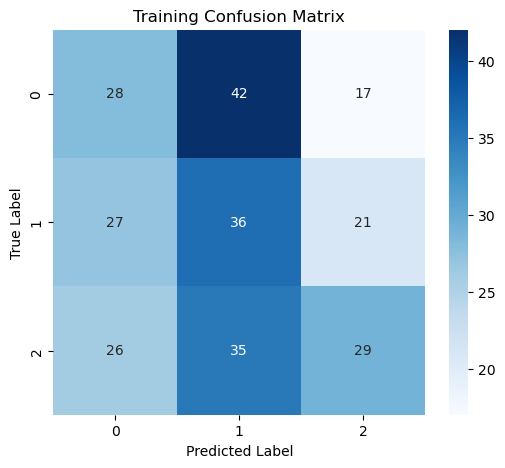

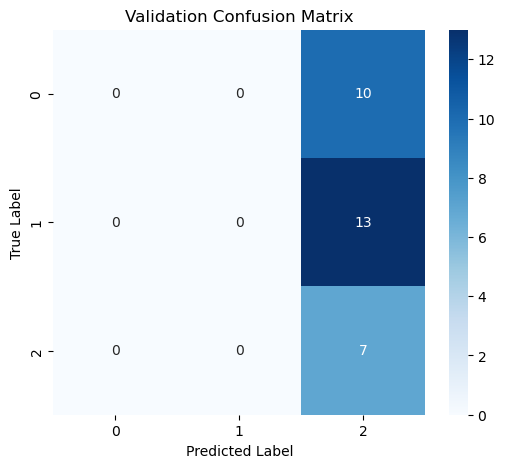

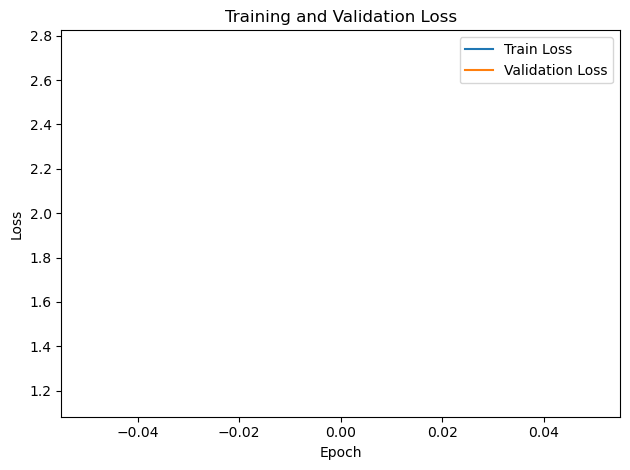

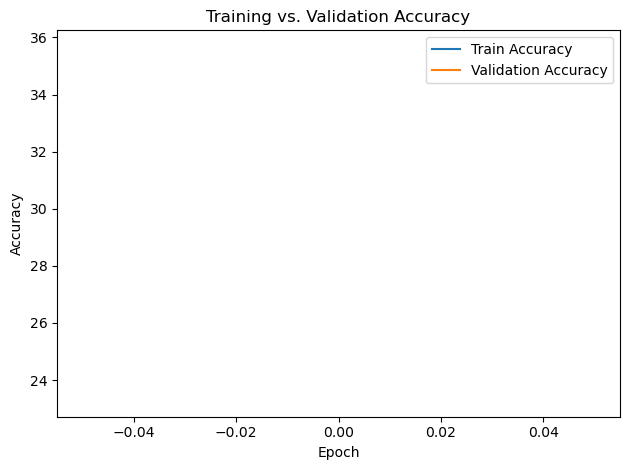

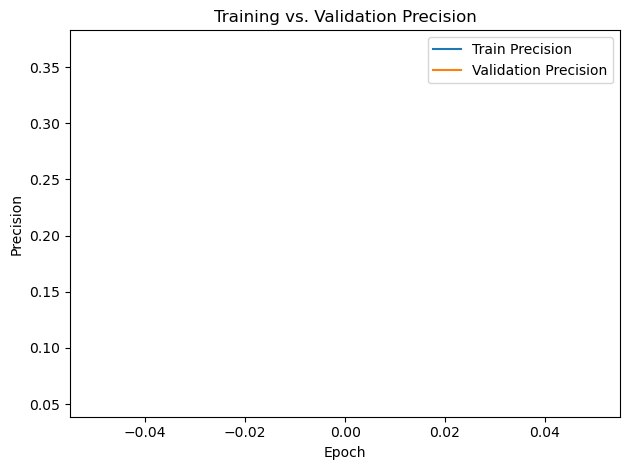

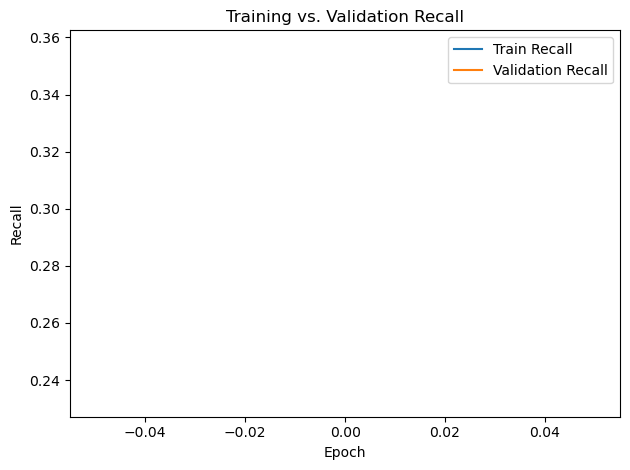

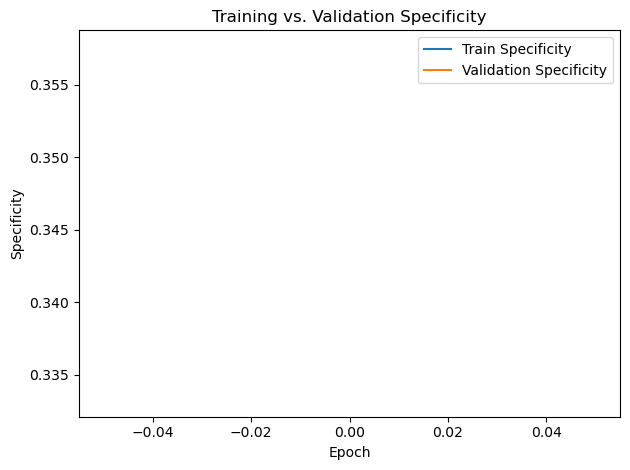

Training complete.
Train label distribution: {0: 83, 1: 89, 2: 90}
Validation label distribution: {0: 11, 1: 10, 2: 8}


/opt/homebrew/Caskroom/miniconda/base/envs/neuroai/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/1] - Loss: 2.3829, Accuracy: 35.88%
 Train - Precision: 0.3570, Recall: 0.3588, F1: 0.3560, Specificity: 0.3579
Validation - Loss: 1.2194, Accuracy: 31.03%
 Validation - Precision: 0.1699, Recall: 0.3103, F1: 0.2146, Specificity: 0.3750


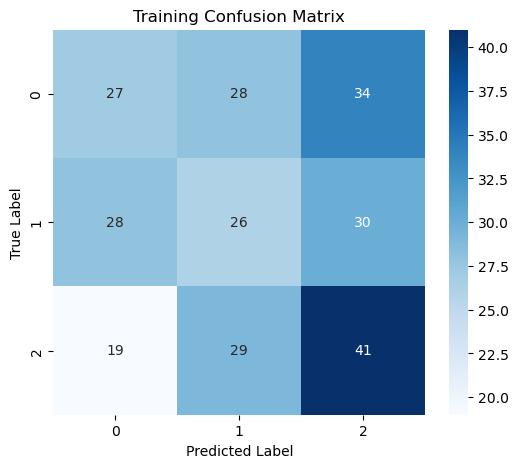

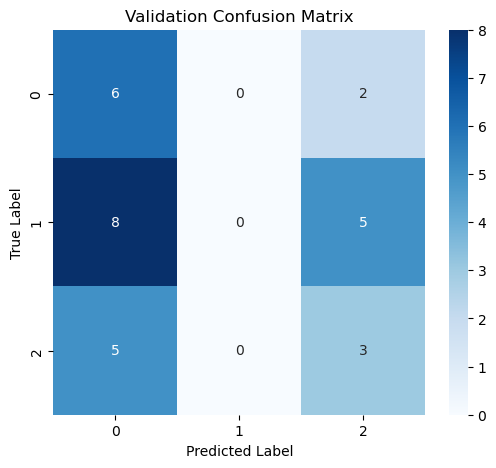

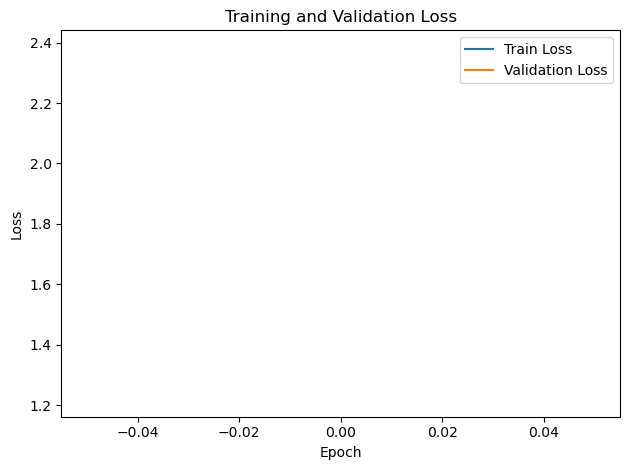

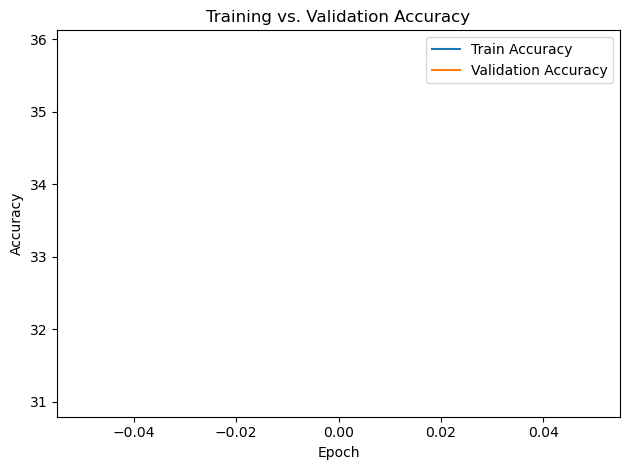

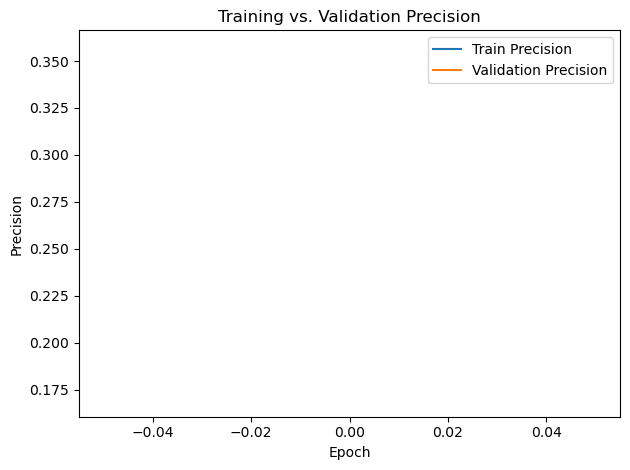

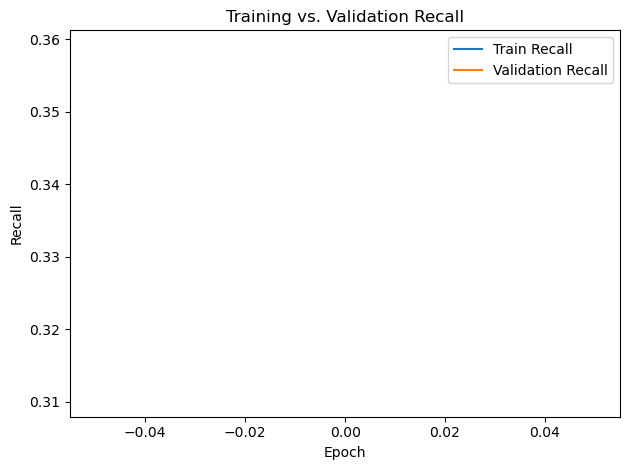

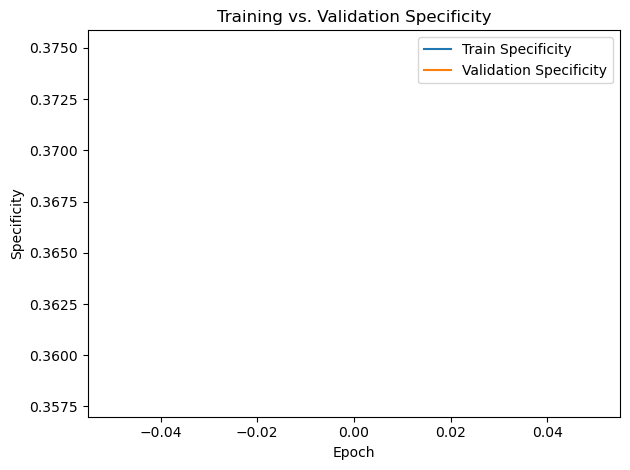

Training complete.
Train label distribution: {0: 82, 1: 92, 2: 88}
Validation label distribution: {0: 12, 1: 7, 2: 10}


/opt/homebrew/Caskroom/miniconda/base/envs/neuroai/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/1] - Loss: 3.3526, Accuracy: 28.24%
 Train - Precision: 0.2761, Recall: 0.2824, F1: 0.2749, Specificity: 0.2796
Validation - Loss: 1.0664, Accuracy: 37.93%
 Validation - Precision: 0.1439, Recall: 0.3793, F1: 0.2086, Specificity: 0.3333


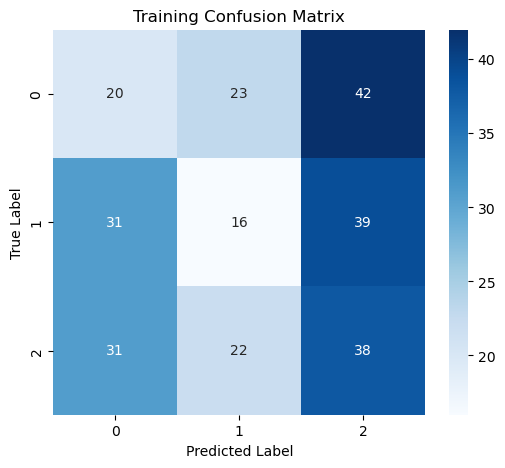

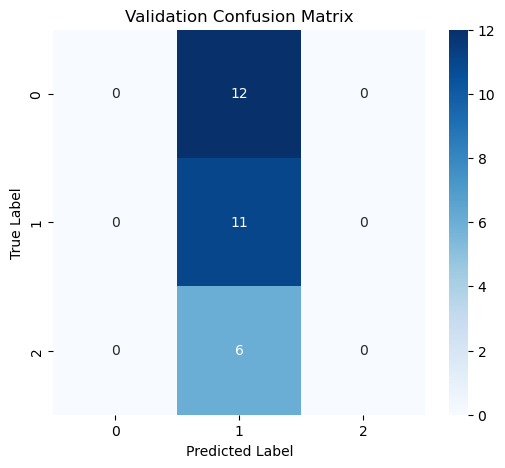

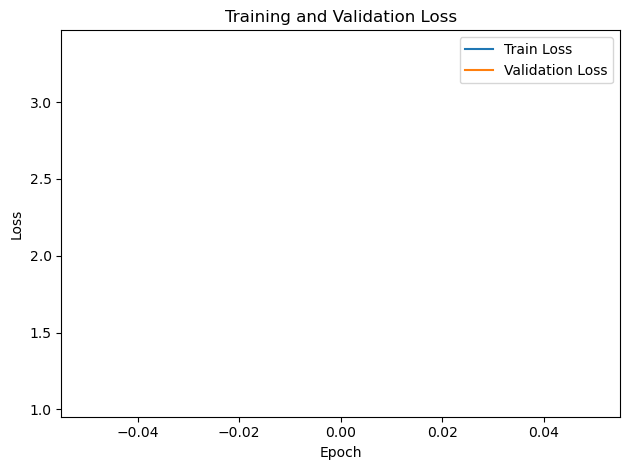

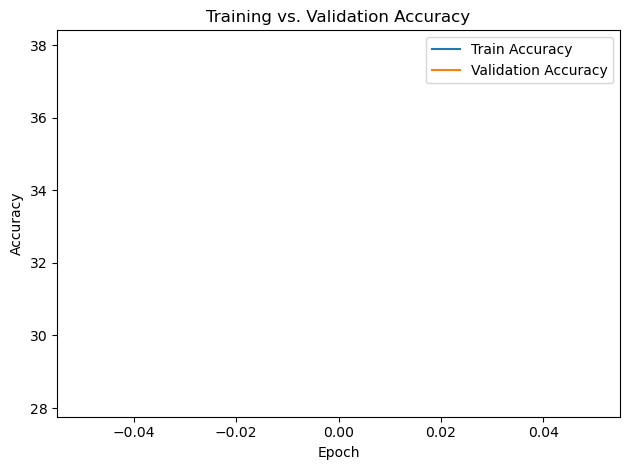

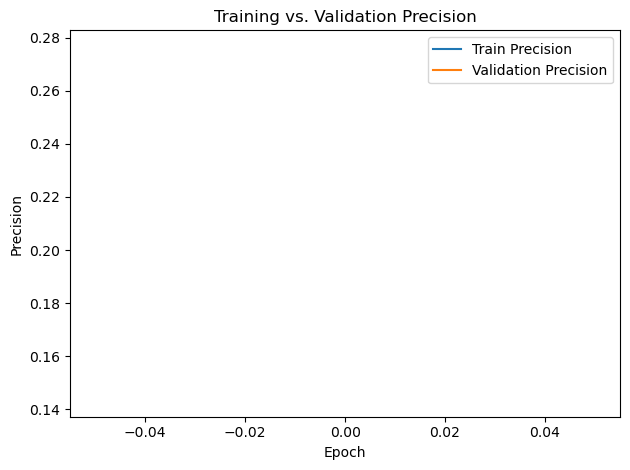

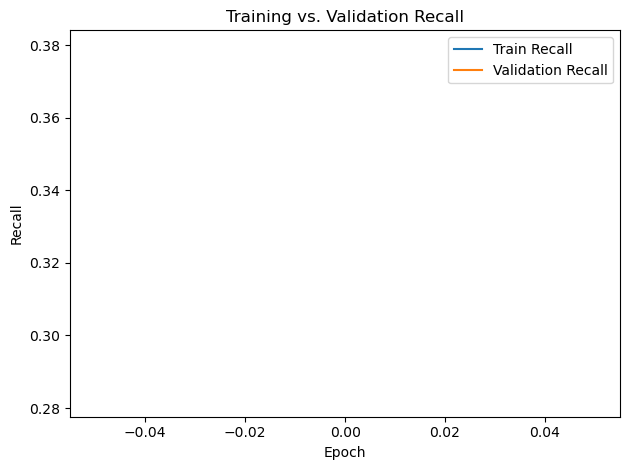

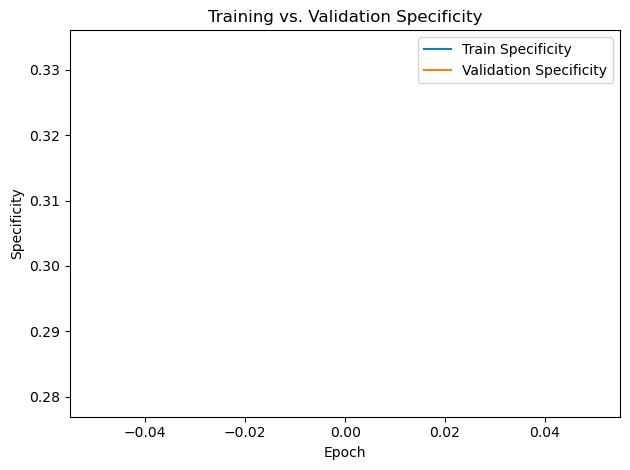

Training complete.
Train label distribution: {0: 81, 1: 93, 2: 88}
Validation label distribution: {0: 13, 1: 6, 2: 10}


/opt/homebrew/Caskroom/miniconda/base/envs/neuroai/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


KeyboardInterrupt: 

In [142]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import gc

device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
data = dataset

X = np.array(data.data['FileName'])
y = np.array(data.data['Label'])

### We want an 80/10/10 Train Val Test Split
### But we also want a 10-Fold Cross Val

# First split into the 90/10 train/test

fold_counter = 0

train_indices, test_indices = train_test_split( 
    list(range(len(data))), test_size=0.1, stratify=y, random_state=42)

train_dataset = Subset(data, train_indices)
test_dataset = Subset(data, test_indices)

folds = KFold(n_splits=10, shuffle=True, random_state=42) 
for fold,(train_index, val_index) in enumerate(folds.split(train_indices)):
    
    train_subset_indices = [train_indices[i] for i in train_index]
    val_subset_indices = [train_indices[i] for i in val_index]

    train_subset = Subset(data, train_subset_indices)
    val_subset = Subset(data, val_subset_indices)

    train_loader = DataLoader(train_subset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=8, shuffle=False)

    train_labels = [data.data.iloc[i, 1] for i in train_index]
    test_labels = [data.data.iloc[i, 1] for i in val_index]

    # Compute class distributions
    unique_labels, train_counts = np.unique(np.array(train_labels), return_counts=True)
    _, test_counts = np.unique(np.array(test_labels), return_counts=True)

    print("Train label distribution:", dict(zip(unique_labels, train_counts)))
    print("Validation label distribution:", dict(zip(unique_labels, test_counts)))

    model = AlexNetMPSDescend().to(device=device)
    model.classifier.apply(lambda m: m.reset_parameters() if type(m) == nn.Linear else None) # make sure the parameters are reset between folds
    full_feature_freeze(model) # freeze the Conv Layers - or whatever else kind of freeze that you want. 
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    val_acc = train_val_model(model, train_loader=train_loader, val_loader=val_loader, criterion=criterion, optimizer=optimizer, num_epochs=1)

    # Flush the GPU of model weights
    del model
    del optimizer
    del criterion
    del train_loader

    gc.collect()
    torch.mps.empty_cache()

# test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)
# test_loss, accuracy, precision, recall, f1_metric, specificity = test_model(model=model, test_loader=test_loader, criterion=criterion, device=device)
# print(f"Test Loss: {test_loss} \n"
#       f"Test Accuracy: {accuracy} \n"
#       f"Test Precision: {precision} \n"
#       f"Test Recall: {recall} \n"
#       f"Test F1: {f1_metric} \n"
#       f"Test Specificity: {specificity}")
# fold_counter += 1


# Grad Cam Stuff

In [ ]:
import cv2

# Add a batch dimension to the input tensor
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_layers()

    def hook_layers(self):
        def forward_hook(module, input, output):
            self.activations = output

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0]

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate_cam(self, input_tensor, target_class):
        self.model.eval()
        output = self.model(input_tensor)
        self.model.zero_grad()
        target = output[0][target_class]
        target.backward()

        gradients = self.gradients.cpu().data.numpy()[0]
        activations = self.activations.cpu().data.numpy()[0]

        weights = np.mean(gradients, axis=(1, 2))
        cam = np.zeros(activations.shape[1:], dtype=np.float32)

        for i, w in enumerate(weights):
            cam += w * activations[i]

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (input_tensor.shape[2], input_tensor.shape[3]))
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        return cam

Ok, so grad_cam works, and we know that the parameter freezing we need to do during a training run. So let's see if we can actually do a mini data pipeline here.

I don't think there is any way of getting around saving the scalograms as PNGs because otherwise you wouldn't get the RGB layers, but that is something to think about.

In any case, I have some saved, I think from one subject. Let's see what they look like again.

tensor([[ -3.0414, -21.5060, -20.4484]], device='mps:0')


/opt/homebrew/Caskroom/miniconda/base/envs/neuroai/lib/python3.12/site-packages/torch/nn/modules/module.py:1805: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


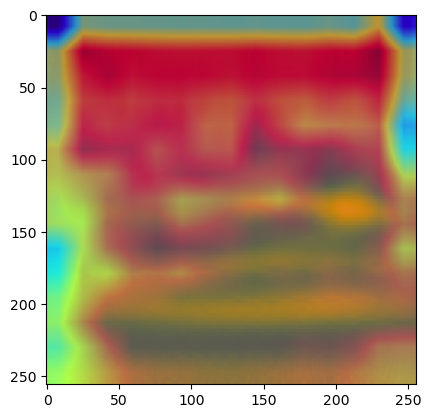

In [100]:
input_image = Image.open("/Users/ciprianbangu/Cogmaster/M2 Internship/BCI code/scalograms_test/images_average/a_average_channel_7.png")
input_tensor = preprocess(input_image)
# Add a batch dimension to the input tensor
input_batch = input_tensor.unsqueeze(dim=0).to(device)

# Ensure the model is in evaluation mode
trained_model.eval()

# Pass the input tensor through the model
with torch.no_grad():
    output = trained_model(input_batch)

print(output)

# Generate Grad-CAM
grad_cam = GradCAM(trained_model, trained_model.features[10])
target_class = output.argmax().item()
cam = grad_cam.generate_cam(input_batch, target_class)

# Convert input image to RGB and visualize the Grad-CAM over the original image
input_image_rgb = input_image.convert("RGB")
input_image_np = np.array(input_image_rgb.resize((input_tensor.shape[1], input_tensor.shape[2])))
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
heatmap = np.float32(heatmap) / 255
overlay = heatmap + np.float32(input_image_np) / 255
overlay = overlay / np.max(overlay)

plt.imshow(overlay)
plt.show()

tensor([[-14.3367,  -4.9464, -13.3994]], device='mps:0')


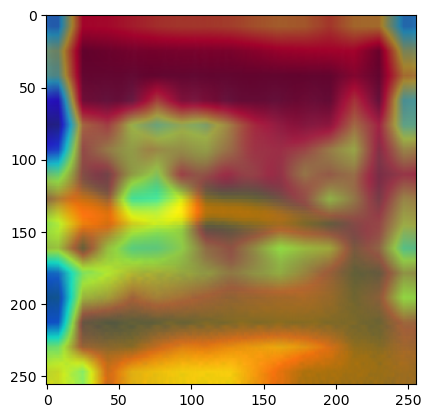

In [101]:
input_image = Image.open("/Users/ciprianbangu/Cogmaster/M2 Internship/BCI code/scalograms_test/images_average/e_average_channel_56.png")
input_tensor = preprocess(input_image)
# Add a batch dimension to the input tensor
input_batch = input_tensor.unsqueeze(dim=0).to(device)

# Ensure the model is in evaluation mode
trained_model.eval()

# Pass the input tensor through the model
with torch.no_grad():
    output = trained_model(input_batch)

print(output)

# Generate Grad-CAM
grad_cam = GradCAM(trained_model, trained_model.features[10])
target_class = output.argmax().item()
cam = grad_cam.generate_cam(input_batch, target_class)

# Convert input image to RGB and visualize the Grad-CAM over the original image
input_image_rgb = input_image.convert("RGB")
input_image_np = np.array(input_image_rgb.resize((input_tensor.shape[1], input_tensor.shape[2])))
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
heatmap = np.float32(heatmap) / 255
overlay = heatmap + np.float32(input_image_np) / 255
overlay = overlay / np.max(overlay)

plt.imshow(overlay)
plt.show()

tensor([[-18.9359, -23.0697,   0.0713]], device='mps:0')


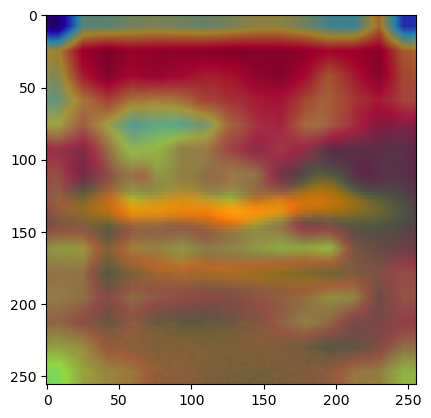

In [103]:
input_image = Image.open("/Users/ciprianbangu/Cogmaster/M2 Internship/BCI code/scalograms_test/images_average/i_average_channel_105.png")
input_tensor = preprocess(input_image)
# Add a batch dimension to the input tensor
input_batch = input_tensor.unsqueeze(dim=0).to(device)

# Ensure the model is in evaluation mode
trained_model.eval()

# Pass the input tensor through the model
with torch.no_grad():
    output = trained_model(input_batch)

print(output)

# Generate Grad-CAM
grad_cam = GradCAM(trained_model, trained_model.features[10])
target_class = output.argmax().item()
cam = grad_cam.generate_cam(input_batch, target_class)

# Convert input image to RGB and visualize the Grad-CAM over the original image
input_image_rgb = input_image.convert("RGB")
input_image_np = np.array(input_image_rgb.resize((input_tensor.shape[1], input_tensor.shape[2])))
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
heatmap = np.float32(heatmap) / 255
overlay = heatmap + np.float32(input_image_np) / 255
overlay = overlay / np.max(overlay)

plt.imshow(overlay)
plt.show()